We have created the GPT model and downloaded the weights from the GPT2 model into our model. Now, it is pre-trained but does not generate related text to what we say, so in order to make the model specialized we are going to finetune the model on a data. I want to create my own model but in order to understand how we finetune exactly, i am going to follow the steps given in the book exactly, and then if time permits i will finetune it on a dataset i like. 

In [1]:
import urllib.request
import zipfile
import os
from pathlib import Path
import torch 
import torch.nn as nn
import tiktoken
from torch.utils.data import Dataset, DataLoader

In [2]:
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (urllib.error.HTTPError, urllib.error.URLError, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [3]:
import pandas as pd 
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df["Label"].value_counts()

ham     4825
spam     747
Name: Label, dtype: int64

The number of non spam msgs are way higher than the spam ones, this would create a bias towards the non spam ones and the model might not be as good as detecting spam msgs. So, we will make the dataset balanced. This is a very important step, we must preprocess any kind of data before training or fine tuning a model.

In [5]:
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0]
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=109)
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])
    return balanced_df

balanced_df = create_balanced_dataset(df)
balanced_df["Label"].value_counts()

ham     747
spam    747
Name: Label, dtype: int64

In [6]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})    
balanced_df

,Label,Text
4882,0,When/where do I pick you up
3715,0,"Oh, i will get paid. The most outstanding one ..."
220,0,Yeah you should. I think you can use your gt a...
1657,0,Yes I posted a couple of pics on fb. There's s...
4245,0,"Aight, I'm chillin in a friend's room so text ..."
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


Now lets split the data into random sets of train, val and test.

In [7]:
def split_rand(df, train_fx, val_fx):
    df = df.sample(frac = 1, random_state=109).reset_index(drop=True)
    
    train_end = int(len(df) * train_fx)
    val_end = train_end + int(len(df)*val_fx)
    
    train_df = df[:train_end]
    val_df = df[train_end:val_end]
    test_df = df[val_end:]
    return train_df, val_df, test_df

train_df, val_df, test_df = split_rand(balanced_df, 0.7, 0.1)

train_df.to_csv("train.csv", index=None)
val_df.to_csv("val.csv", index=None)
test_df.to_csv("test.csv", index=None)
tokenizer = tiktoken.get_encoding("gpt2")

/home/salaj/anaconda3/envs/dl-env/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [8]:
class SpamDataset(Dataset):
    def __init__(self, csv, tokenizer,max_lenght = None, pad_token_id = 50256):
        self.data = pd.read_csv(csv)
        self.encoded_txt = [tokenizer.encode(txt) for txt in self.data["Text"]]
        if max_lenght is None :
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_lenght
            self.encoded_txt = [encoded_text[:self.max_length]
                                for encoded_text in self.encoded_txt]
        
        self.encoded_txt = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_txt
        ]
        
    def __getitem__(self, index):
        encoded = self.encoded_txt[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_txt:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [9]:
train_dataset = SpamDataset(csv="train.csv", max_lenght=None, tokenizer=tokenizer)
val_dataset = SpamDataset(csv="val.csv", max_lenght=train_dataset.max_length, tokenizer=tokenizer)
test_dataset = SpamDataset(csv="test.csv", max_lenght=train_dataset.max_length, tokenizer=tokenizer)
train_dataset.max_length

94

In [10]:
num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

print(len(train_loader), len(val_loader), len(test_loader))

130 19 38


 Now we will initialize the pre-trained model

In [11]:
from important_GPT_blocks import download_weights
download_weights()

In [12]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [13]:
from gpt_download import download_and_load_gpt2
from important_GPT_blocks import GPTModel
from load_weights import load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [14]:
from add_training_data import text_to_token_ids, token_ids_to_text
from important_GPT_blocks import simple_text_gen

text_1 = "With great power comes great"

token_ids = simple_text_gen(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

With great power comes great power, and the only way to get it, the first time I saw


In [15]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)
token_ids = simple_text_gen(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

'The first time I was in the office of the 'C' and 'I' said to me


So now the model has dowanloaded the gpt2 model and is using it to generate text, we just need to add a classification head and train it to classify the messages as spam or ham.

In [16]:
model

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [17]:
for param in model.parameters():
    param.requires_grad = False
    
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

In [18]:
inputs = tokenizer.encode("There was a guy named")
inputs = torch.tensor(inputs).unsqueeze(0)
inputs

tensor([[1858,  373,  257, 3516, 3706]])

In [19]:
with torch.no_grad():
    output = model(inputs)
    
output

tensor([[[-0.6904,  1.1111],
         [-1.6895,  5.3574],
         [-3.0605,  5.0846],
         [-2.7163,  4.8241],
         [-2.6445,  3.8505]]])

In [20]:
output[:, -1, :]
label = torch.argmax(output[:,-1,:])
label.item()

1

In [21]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) 

torch.manual_seed(123)

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 47.50%
Validation accuracy: 50.00%
Test accuracy: 52.50%


In [23]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :] 
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [24]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 3.274
Validation loss: 2.936
Test loss: 3.067


Till now we have seen that the loss is high and the accuracy is low. This is because we have not fine tuned the model yet. Basically, we stoppped the gradient descent and disallowed the model to train its weights, then applied a classification head which had only 2 outputs, spam or not spam rather than 50257 outputs like earlier. THen unfreezing the bottom layers to make the model working again, the model is working well now it can understand the text and is able to classify into two categories, its just that it has not been taught which are spam and which arent. So, now we will train/fine tune it, for that we will use cross entropy loss because classification is a boolean property in terms of our problem, so we won't be able to define a loss function as it wont be differentiable. Thus, instead we use the cross-entropy loss considering 1 as the spam and 0 as non spam and compute the loss accordingly.

In [30]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train() 

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() 
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step() 
            examples_seen += input_batch.shape[0]
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

These above functions are similar to the ones we defined in chapter 5 while training our GPT model.

In [35]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.135, Val loss 0.272
Ep 1 (Step 000050): Train loss 0.269, Val loss 0.190
Ep 1 (Step 000100): Train loss 0.155, Val loss 0.177
Training accuracy: 95.00% | Validation accuracy: 92.50%
Ep 2 (Step 000150): Train loss 0.078, Val loss 0.162
Ep 2 (Step 000200): Train loss 0.205, Val loss 0.172
Ep 2 (Step 000250): Train loss 0.087, Val loss 0.165
Training accuracy: 95.00% | Validation accuracy: 95.00%
Ep 3 (Step 000300): Train loss 0.093, Val loss 0.218
Ep 3 (Step 000350): Train loss 0.201, Val loss 0.271
Training accuracy: 97.50% | Validation accuracy: 97.50%
Ep 4 (Step 000400): Train loss 0.013, Val loss 0.106
Ep 4 (Step 000450): Train loss 0.022, Val loss 0.106
Ep 4 (Step 000500): Train loss 0.007, Val loss 0.103
Training accuracy: 97.50% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.262, Val loss 0.163
Ep 5 (Step 000600): Train loss 0.016, Val loss 0.103
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 6 (Step 000650): Train loss

In [36]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()  
    ax2.plot(examples_seen, train_values, alpha=0)  
    ax2.set_xlabel("Examples seen")

    fig.tight_layout() 
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

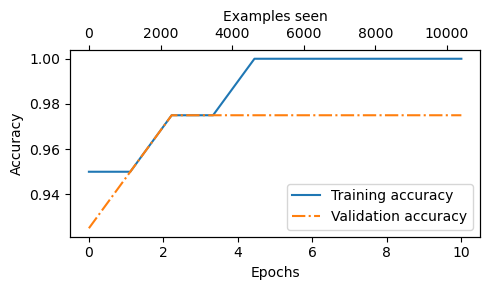

In [37]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [38]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 99.90%
Validation accuracy: 96.64%
Test accuracy: 96.67%


training for 10 epochs rather than 5 trained it much better, highly increasing the accuracy. Now i will use the test cases given in the book as it is, to test the model and then later try my own statments.

In [39]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    input_ids = input_ids[:min(max_length, supported_context_length)]
    assert max_length is not None, (
        "max_length must be specified. If you want to use the full model context, "
        "pass max_length=model.pos_emb.weight.shape[0]."
    )
    assert max_length <= supported_context_length, (
        f"max_length ({max_length}) exceeds model's supported context length ({supported_context_length})."
    )    
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

In [40]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [41]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [46]:
text_2 = (
    "Let's meet for a date and discuss the opportunity further"
    "You have won the gift and will recieve a prize"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [42]:
torch.save(model.state_dict(), "review_classifier.pth")

Works amazinglyy!!